In [5]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.stats import zscore
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
import tensorflow as tf

from scipy import signal

from scipy.stats import entropy
import re
import random
from collections import defaultdict

import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

import json


## Valid data

In [6]:
base_dir = 'data/PlantSounds'

categories = [
    'Tomato Dry',
    'Empty Pot',
    'Greenhouse Noises',
    'Tobacco Cut',
    'Tobacco Dry',
    'Tomato Cut'
]

for category in categories:
    path = os.path.join(base_dir, category)
    if os.path.exists(path):
        print(f"{path}, {len(os.listdir(path))} items")
    else:
        print(f"{path} does not exist!")

data/PlantSounds/Tomato Dry, 1622 items
data/PlantSounds/Empty Pot, 1036 items
data/PlantSounds/Greenhouse Noises, 1378 items
data/PlantSounds/Tobacco Cut, 506 items
data/PlantSounds/Tobacco Dry, 275 items
data/PlantSounds/Tomato Cut, 660 items


## Feature Extraction Methods

### 1.1 Deep Scattering Network

Implement using ScatNet with Morlet wavelets

Input: 2ms sound segment at 500 kHz (1000 sample points)

Output: Feature vector of transformed coefficients

In [7]:
def morlet_wavelet(width, omega):
    """Create a Morlet wavelet function"""
    x = np.linspace(-width/2, width/2, width)
    envelope = np.exp(-x**2/(2*(width/8)**2))
    wavelet = envelope * np.exp(1j * omega * x)
    return wavelet

def create_wavelet_filters(n_wavelets_per_octave, n_octaves, sample_rate, q_factor=1, max_width=None):
    """Create a bank of Morlet wavelets filters with limited width"""
    filters = []

    # Base frequency
    min_freq = 20  # Hz
    max_freq = sample_rate / 2  # Nyquist frequency

    # Calculate frequencies
    n_filters = n_wavelets_per_octave * n_octaves
    freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_filters)

    for freq in freqs:
        # Calculate width based on Q-factor
        width = int(sample_rate * q_factor / freq)
        # Ensure width is odd
        if width % 2 == 0:
            width += 1
        # Ensure width is not too small or too large
        width = max(width, 5)
        if max_width is not None:
            width = min(width, max_width)

        # Create wavelet
        omega = 2 * np.pi * freq / sample_rate
        wavelet = morlet_wavelet(width, omega)

        # Convert to TensorFlow tensor
        wavelet_tensor = tf.convert_to_tensor(wavelet, dtype=tf.complex64)
        filters.append(wavelet_tensor)

    return filters

def convolve_tf(x, f):
    """Safely convolve signal x with filter f using FFT"""
    # Ensure f is not longer than x
    if tf.shape(f)[0] > tf.shape(x)[0]:
        f = f[:tf.shape(x)[0]]

    # Zero-pad f to match x's length
    padded_f = tf.concat([f, tf.zeros(tf.shape(x)[0] - tf.shape(f)[0], dtype=f.dtype)], axis=0)

    # Perform convolution via FFT
    fft_x = tf.signal.fft(tf.cast(x, tf.complex64))
    fft_f = tf.signal.fft(padded_f)
    conv = tf.signal.ifft(fft_x * fft_f)

    return conv

def scatter_transform_layer(x, filters, lowpass_filter):
    """Apply scattering transform for one layer"""
    outputs = []
    modulus_outputs = []

    # Apply each wavelet filter
    for f in filters:
        # Complex convolution
        conv = convolve_tf(x, f)

        # Calculate modulus
        modulus = tf.abs(conv)
        modulus_outputs.append(modulus)

        # Apply lowpass filter to smooth
        lowpass_real = tf.cast(lowpass_filter, tf.complex64)
        smoothed_complex = convolve_tf(modulus, lowpass_real)
        smoothed = tf.abs(smoothed_complex)

        outputs.append(smoothed)

    return outputs, modulus_outputs

def create_lowpass_filter(width, cutoff, sample_rate):
    """Create a lowpass filter"""
    nyquist = sample_rate / 2
    normalized_cutoff = cutoff / nyquist
    filt = signal.firwin(width, normalized_cutoff)
    return tf.convert_to_tensor(filt, dtype=tf.float32)

def extract_features_from_transform(transform_outputs, n_features=100):
    """Extract fixed number of features from transform outputs"""
    features = []

    # For each filter output, compute statistics
    for output in transform_outputs:
        output_np = output.numpy()
        features.append(np.mean(output_np))
        features.append(np.std(output_np))
        features.append(np.max(output_np))

        # Add some frequency domain features
        fft_mag = np.abs(np.fft.rfft(output_np))
        if len(fft_mag) > 0:
            features.append(np.mean(fft_mag))
            features.append(np.max(fft_mag))
            # Add spectral centroid
            if np.sum(fft_mag) > 0:
                indices = np.arange(len(fft_mag))
                centroid = np.sum(indices * fft_mag) / np.sum(fft_mag)
                features.append(centroid)
            else:
                features.append(0)
        else:
            # Pad with zeros if FFT is empty
            features.extend([0, 0, 0])

    # Ensure we have exactly n_features
    features = np.array(features)
    if len(features) >= n_features:
        # Truncate if we have too many
        return features[:n_features]
    else:
        # Pad with zeros if we don't have enough
        padded = np.zeros(n_features)
        padded[:len(features)] = features
        return padded

def deep_scattering_transform(audio, sample_rate=500000, n_layers=2,
                             lowpass_width=2**8, q_factor=1, n_wavelets_per_octave=8):
    """Apply deep scattering transform to audio"""
    # Convert to TensorFlow tensor
    x = tf.convert_to_tensor(audio, dtype=tf.float32)
    signal_length = tf.shape(x)[0]

    # Limit wavelet width
    max_wavelet_width = signal_length.numpy() // 2

    # Create wavelet filters - limit number to save computation
    n_octaves = min(int(np.log2(sample_rate / 20)), 6)  # Reduce octaves to limit filters
    n_wavelets_per_octave = min(n_wavelets_per_octave, 4)  # Limit wavelets per octave

    filters = create_wavelet_filters(n_wavelets_per_octave, n_octaves, sample_rate,
                                    q_factor, max_width=max_wavelet_width)

    # Create lowpass filter
    lowpass_width = min(lowpass_width, signal_length.numpy() // 2)
    lowpass_cutoff = 100  # Hz
    lowpass_filter = create_lowpass_filter(lowpass_width, lowpass_cutoff, sample_rate)

    # First layer
    layer1_outputs, layer1_modulus = scatter_transform_layer(x, filters, lowpass_filter)
    all_outputs = layer1_outputs

    # Second layer (if requested)
    if n_layers >= 2:
        # Limit computation by using fewer modulus outputs
        max_second_layer = min(len(layer1_modulus), 3)  # Only use first few modulus outputs
        for i in range(max_second_layer):
            layer2_out, _ = scatter_transform_layer(layer1_modulus[i], filters[:max_second_layer], lowpass_filter)
            all_outputs.extend(layer2_out)

    return all_outputs

def extract_scatnet_features(file_path, segment_duration=0.002, target_sr=500000, n_features=100):
    """Extract ScatNet features from an audio file"""
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=target_sr)

        # Ensure we have enough samples
        expected_samples = int(segment_duration * target_sr)
        if len(audio) < expected_samples:
            audio = np.pad(audio, (0, expected_samples - len(audio)))

        # Use just the first segment
        audio = audio[:expected_samples]

        # Apply scattering transform
        transform_outputs = deep_scattering_transform(
            audio,
            sample_rate=target_sr,
            n_layers=2,
            lowpass_width=min(2**8, expected_samples // 4),
            q_factor=1,
            n_wavelets_per_octave=8
        )

        # Extract fixed number of features
        features = extract_features_from_transform(transform_outputs, n_features)

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        # Return zero vector as fallback
        return np.zeros(n_features)


Testing with file: data/PlantSounds/Tomato Dry/id_33_sound_4.wav
Audio loaded: 1001 samples at 500000Hz (duration: 0.002s)


2025-04-14 21:39:47.472893: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-14 21:39:47.473079: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-14 21:39:47.473272: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-14 21:39:47.473322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-14 21:39:47.473518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Feature shape: (100,)
Feature min: 0.0011, max: 6.3316, mean: 0.6802


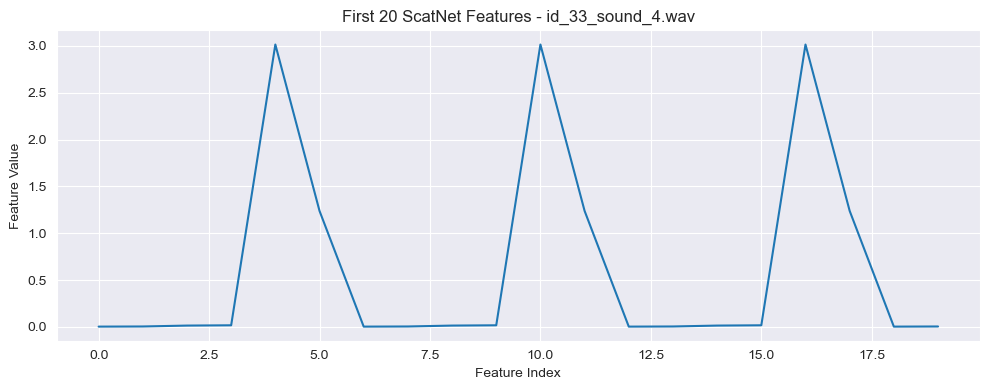

ScatNet feature extraction test completed successfully!


array([3.01532052e-03, 4.46861889e-03, 1.41018303e-02, 1.70839164e-02,
       3.01532044e+00, 1.23855896e+00, 3.01525299e-03, 4.46859887e-03,
       1.41017772e-02, 1.70837958e-02, 3.01525298e+00, 1.23857723e+00,
       3.01510002e-03, 4.46855370e-03, 1.41016589e-02, 1.70835242e-02,
       3.01510014e+00, 1.23861919e+00, 3.01475357e-03, 4.46845125e-03,
       1.41013898e-02, 1.70829052e-02, 3.01475350e+00, 1.23868857e+00,
       3.01396661e-03, 4.46822029e-03, 1.41007807e-02, 1.70815038e-02,
       3.01396668e+00, 1.23886451e+00, 3.01218289e-03, 4.46770340e-03,
       1.40994061e-02, 1.70783376e-02, 3.01218308e+00, 1.23928908e+00,
       3.00815934e-03, 4.46656346e-03, 1.40963383e-02, 1.70712308e-02,
       3.00815934e+00, 1.24024724e+00, 2.99919210e-03, 4.46412712e-03,
       1.40896365e-02, 1.70555493e-02, 2.99919194e+00, 1.24251416e+00,
       2.97990604e-03, 4.45924141e-03, 1.40757496e-02, 1.70224808e-02,
       2.97990620e+00, 1.24813701e+00, 2.94258422e-03, 4.45058895e-03,
      

In [8]:
def test_scatnet_feature_extraction():
    """Test ScatNet feature extraction on a sample file"""
    # Find the first available audio file
    audio_file = None
    for category in categories:
        path = os.path.join(base_dir, category)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.wav')]
            if files:
                audio_file = os.path.join(path, files[0])
                break

    if audio_file is None:
        print("No audio files found!")
        return

    print(f"Testing with file: {audio_file}")

    # Load audio to see what we're working with
    try:
        audio, sr = librosa.load(audio_file, sr=None)
        print(f"Audio loaded: {len(audio)} samples at {sr}Hz (duration: {len(audio)/sr:.3f}s)")

        # Extract features
        features = extract_scatnet_features(
            audio_file,
            segment_duration=0.002,
            target_sr=500000,
            n_features=100
        )

        print(f"Feature shape: {features.shape}")
        print(f"Feature min: {features.min():.4f}, max: {features.max():.4f}, mean: {features.mean():.4f}")

        # Plot first 20 features to reduce clutter
        plt.figure(figsize=(10, 4))
        plt.plot(features[:20])
        plt.title(f"First 20 ScatNet Features - {os.path.basename(audio_file)}")
        plt.xlabel("Feature Index")
        plt.ylabel("Feature Value")
        plt.tight_layout()
        plt.show()

        print("ScatNet feature extraction test completed successfully!")
        return features
    except Exception as e:
        print(f"Error during feature extraction: {e}")
        import traceback
        traceback.print_exc()

test_scatnet_feature_extraction()


### 1.2 MFCC (Mel-frequency cepstral coefficients)
- Apply windowing with 1ms Hamming windows and 0.5ms overlap
- Normalize features using Z-score normalization

In [9]:
import warnings
from contextlib import contextmanager
@contextmanager
def suppress_librosa_warnings():
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='Empty filters detected in mel frequency basis.*')
        warnings.filterwarnings('ignore', message='n_fft=.* is too large for input signal.*')
        yield

def extract_mfcc_features(file_path,
                         n_mfcc=13,
                         n_mels=40,
                         window_length_ms=1,
                         hop_length_ms=0.5,
                         normalize=True):
    """
    Extract MFCC features from an audio file with specified configuration

    Parameters:
    -----------
    file_path : str
        Path to audio file
    n_mfcc : int
        Number of MFCC coefficients to extract
    n_mels : int
        Number of Mel filter banks to use
    window_length_ms : float
        Window length in milliseconds
    hop_length_ms : float
        Hop length in milliseconds
    normalize : bool
        Whether to apply Z-score normalization

    Returns:
    --------
    features : ndarray
        Normalized MFCC features (39 coefficients per frame)
    """
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)

        # For very short audio files, we need to adjust parameters
        duration_ms = 1000 * len(y) / sr
        print(f"Audio duration: {duration_ms:.2f} ms")

        # Ensure window_length is reasonable for the audio length
        window_length_ms = min(window_length_ms, duration_ms / 2)
        hop_length_ms = min(hop_length_ms, window_length_ms / 2)

        # Convert window and hop lengths from ms to samples
        window_length = max(int(window_length_ms * sr / 1000), 4)
        hop_length = max(int(hop_length_ms * sr / 1000), 2)

        print(f"Using window_length={window_length} samples, hop_length={hop_length} samples")

        # Ensure window_length is even
        if window_length % 2 != 0:
            window_length += 1

        # For very short files, pad the signal
        if len(y) < 3 * window_length:
            padding = 3 * window_length - len(y)
            y = np.pad(y, (0, padding), mode='constant')
            print(f"Padded audio to {len(y)} samples")

        # Set appropriate n_fft value
        n_fft = 2**int(np.log2(len(y)))
        n_fft = min(n_fft, 1024)
        print(f"Using n_fft={n_fft}")

        # Adjust mel filter parameters
        max_mels = n_fft // 4  # Reduce max_mels to avoid empty filters
        n_mels = min(n_mels, max_mels)

        # Adjust frequency range for mel filters
        fmin = 20  # Standard minimum frequency
        fmax = min(sr/2, 8000)  # Cap maximum frequency

        print(f"Using n_mels={n_mels}, fmin={fmin}Hz, fmax={fmax}Hz")

        # Extract MFCCs with adjusted parameters
        with suppress_librosa_warnings():
            mfccs = librosa.feature.mfcc(
                y=y,
                sr=sr,
                n_mfcc=n_mfcc,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                win_length=window_length,
                hop_length=hop_length,
                window='hamming'
            )

        print(f"MFCC shape: {mfccs.shape}")

        # Calculate delta features
        width = min(9, max(3, mfccs.shape[1] - 2))
        width = width if width % 2 == 1 else width - 1
        print(f"Using delta width={width}")

        delta_mfccs = librosa.feature.delta(mfccs, width=width)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2, width=width)

        # Combine features
        features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)
        features = features.T

        # Apply Z-score normalization if requested
        if normalize and features.shape[0] > 1:
            scaler = StandardScaler()
            features = scaler.fit_transform(features)

        return features

    except Exception as e:
        print(f"Error extracting MFCC features from {file_path}: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros((1, n_mfcc * 3))

In [10]:
def summarize_mfcc_features(features):
    """Summarize MFCC features by computing statistics across frames"""
    if features.shape[0] <= 1:
        # If we have only one frame, just return it
        return features.flatten()

    # Compute statistics across frames
    mean_features = np.mean(features, axis=0)
    std_features = np.std(features, axis=0)
    max_features = np.max(features, axis=0)
    min_features = np.min(features, axis=0)

    # Combine statistics into one feature vector
    summary = np.concatenate([mean_features, std_features, max_features, min_features])

    return summary

Testing MFCC extraction with file: data/PlantSounds/Tomato Dry/id_33_sound_4.wav
Audio loaded: 1001 samples at 500000Hz (duration: 0.002s)
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
MFCC feature shape: (7, 39) (frames × features)
Feature min: -1.8942, max: 1.9448, mean: -0.0000
Summary feature shape: (156,)


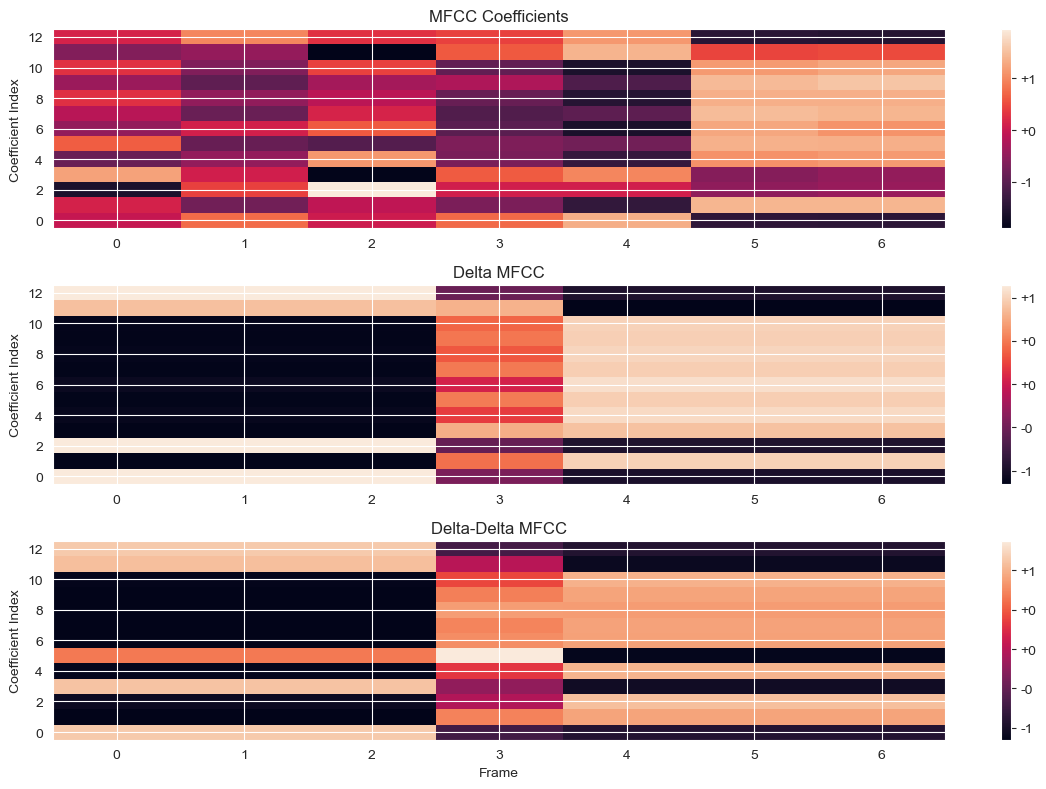

MFCC feature extraction test completed successfully!


array([[-0.03272863,  0.11699722, -1.6052443 ,  1.2374451 , -0.84460664,
         0.6436899 , -0.48163682, -0.14255033,  0.27144924, -0.39458242,
         0.28617352, -0.6241818 ,  0.14317998,  1.1354729 , -1.1373587 ,
         1.1441537 , -1.1538676 , -1.1106298 , -1.1413937 , -1.0881081 ,
        -1.1410348 , -1.1263921 , -1.1394807 , -1.1323631 ,  0.88618416,
         1.1427454 ,  1.1521899 , -1.1522641 , -1.0723238 ,  1.1134113 ,
        -1.123619  ,  0.66438705, -1.1538489 , -1.1527125 , -1.1546935 ,
        -1.1516947 , -1.132731  ,  1.0810758 ,  1.1515508 ],
       [ 0.7585949 , -0.7828855 ,  0.4259548 ,  0.09969396, -0.47700843,
        -0.87316465,  0.10318673, -0.85558397, -0.4991859 , -0.9419182 ,
        -0.6369824 , -0.46026433,  0.98452765,  1.1354729 , -1.1373587 ,
         1.1441537 , -1.1538676 , -1.1106298 , -1.1413937 , -1.0881081 ,
        -1.1410348 , -1.1263921 , -1.1394807 , -1.1323631 ,  0.88618416,
         1.1427454 ,  1.1521899 , -1.1522641 , -1.0723238 ,  1.

In [11]:
def test_mfcc_feature_extraction():
    """Test MFCC feature extraction on a sample file"""
    # Find the first available audio file
    audio_file = None
    for category in categories:
        path = os.path.join(base_dir, category)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.wav')]
            if files:
                audio_file = os.path.join(path, files[0])
                break

    if audio_file is None:
        print("No audio files found!")
        return

    print(f"Testing MFCC extraction with file: {audio_file}")

    # Load audio to see what we're working with
    try:
        audio, sr = librosa.load(audio_file, sr=None)
        duration = len(audio) / sr
        print(f"Audio loaded: {len(audio)} samples at {sr}Hz (duration: {duration:.3f}s)")

        # Extract MFCC features
        features = extract_mfcc_features(
            audio_file,
            n_mfcc=13,
            n_mels=40,
            window_length_ms=1,
            hop_length_ms=0.5,
            normalize=True
        )

        print(f"MFCC feature shape: {features.shape} (frames × features)")
        print(f"Feature min: {features.min():.4f}, max: {features.max():.4f}, mean: {features.mean():.4f}")

        # Summary features for classification
        summary_features = summarize_mfcc_features(features)
        print(f"Summary feature shape: {summary_features.shape}")

        # Plot features if we have more than one frame
        if features.shape[0] > 1:
            plt.figure(figsize=(12, 8))

            # Plot original MFCCs (first 13 coefficients)
            plt.subplot(3, 1, 1)
            plt.imshow(features[:, :13].T, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f')
            plt.title('MFCC Coefficients')
            plt.ylabel('Coefficient Index')

            # Plot delta MFCCs
            plt.subplot(3, 1, 2)
            plt.imshow(features[:, 13:26].T, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f')
            plt.title('Delta MFCC')
            plt.ylabel('Coefficient Index')

            # Plot delta-delta MFCCs
            plt.subplot(3, 1, 3)
            plt.imshow(features[:, 26:].T, aspect='auto', origin='lower')
            plt.colorbar(format='%+2.0f')
            plt.title('Delta-Delta MFCC')
            plt.xlabel('Frame')
            plt.ylabel('Coefficient Index')

            plt.tight_layout()
            plt.show()
        else:
            # Just plot the feature vector for a single frame
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 1, 1)
            plt.bar(range(features.shape[1]), features[0])
            plt.title('MFCC Features (Single Frame)')
            plt.xlabel('Feature Index')
            plt.ylabel('Feature Value')
            plt.tight_layout()
            plt.show()

        print("MFCC feature extraction test completed successfully!")
        return features
    except Exception as e:
        print(f"Error during MFCC feature extraction: {e}")
        import traceback
        traceback.print_exc()

test_mfcc_feature_extraction()


### 1.3 Basic Audio Feature Extraction Implementation
   - Extract the following time and frequency domain features:
     - **Energy**: Sum of squared amplitude values
     - **Energy Entropy**: Entropy of normalized energy in sub-frames (divide the 2ms into 8 sub-frames)
     - **Spectral Entropy**: Entropy of the normalized FFT magnitude spectrum
     - **Maximum Frequency**: Frequency with highest amplitude in spectrum
   - Calculate FFT with 1024 points for frequency analysis
   - Ensure all features are normalized to be on comparable scales

In [12]:
def extract_basic_features(file_path, n_subframes=8):
    """
    Extract basic time and frequency domain features from an audio file

    Parameters:
    -----------
    file_path : str
        Path to audio file
    n_subframes : int
        Number of sub-frames to divide the signal for energy entropy calculation

    Returns:
    --------
    features : dict
        Dictionary containing the extracted features
    """
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=None)

        # Determine appropriate FFT size (power of 2 less than or equal to signal length)
        n_fft = 2**int(np.log2(len(y)))
        # If the signal is very short, pad it for analysis
        if len(y) < 1024:
            # Calculate how much padding we need
            pad_length = 1024 - len(y)
            # Pad the signal
            y_padded = np.pad(y, (0, pad_length), mode='constant')
            # Now we can use n_fft=1024
            n_fft = 1024
        else:
            y_padded = y

        print(f"Using n_fft={n_fft} for a signal of length {len(y)}")

        # Time domain features
        # 1. Energy: Sum of squared amplitude values
        energy = np.sum(y**2)

        # 2. Energy Entropy: Entropy of normalized energy in sub-frames
        # Divide the signal into n_subframes sub-frames (minimum of 1 sample per subframe)
        subframe_length = max(1, len(y) // n_subframes)
        subframe_energy = np.zeros(n_subframes)

        for i in range(n_subframes):
            start = i * subframe_length
            end = min(start + subframe_length, len(y))
            if start >= len(y):
                break
            subframe = y[start:end]
            subframe_energy[i] = np.sum(subframe**2) if len(subframe) > 0 else 0

        # Normalize the sub-frame energies (add small constant to avoid log(0))
        total_energy = np.sum(subframe_energy)
        if total_energy > 0:
            subframe_energy_norm = subframe_energy / (total_energy + 1e-10)
            energy_entropy = entropy(subframe_energy_norm)
        else:
            energy_entropy = 0

        # Frequency domain features using padded signal
        # Compute the FFT directly to avoid STFT issues
        fft_result = np.fft.rfft(y_padded, n=n_fft)
        magnitude_spectrum = np.abs(fft_result)

        # 3. Spectral Entropy: Entropy of the normalized magnitude spectrum
        total_magnitude = np.sum(magnitude_spectrum)
        if total_magnitude > 0:
            magnitude_spectrum_norm = magnitude_spectrum / (total_magnitude + 1e-10)
            spectral_entropy = entropy(magnitude_spectrum_norm)
        else:
            spectral_entropy = 0

        # 4. Maximum Frequency: Frequency with highest amplitude in spectrum
        max_bin = np.argmax(magnitude_spectrum)
        max_frequency = max_bin * sr / n_fft

        # Additional features
        # 5. Spectral Centroid: Center of gravity of the spectrum
        if total_magnitude > 0:
            freqs = np.fft.rfftfreq(n_fft, 1/sr)
            spectral_centroid = np.sum(freqs * magnitude_spectrum) / (total_magnitude + 1e-10)
        else:
            spectral_centroid = 0

        # 6. Zero Crossing Rate: Rate of sign changes in the signal
        zero_crossings = np.sum(np.abs(np.diff(np.signbit(y))))
        zero_crossing_rate = zero_crossings / (len(y) - 1) if len(y) > 1 else 0

        # Create a dictionary of features
        features = {
            'energy': energy,
            'energy_entropy': energy_entropy,
            'spectral_entropy': spectral_entropy,
            'max_frequency': max_frequency,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }

        # Normalize the features based on typical ranges for audio signals
        # These ranges are approximate and should be adjusted based on your specific dataset

        # Energy: Normalize relative to a reference energy level (e.g., 1.0)
        energy_normalized = min(1.0, energy / 1.0)

        # Energy Entropy: Typically ranges from 0 to log(n_subframes)
        max_energy_entropy = np.log(n_subframes)
        energy_entropy_normalized = energy_entropy / max_energy_entropy if max_energy_entropy > 0 else 0

        # Spectral Entropy: Typically ranges from 0 to log(n_fft/2 + 1)
        max_spectral_entropy = np.log(n_fft//2 + 1)
        spectral_entropy_normalized = spectral_entropy / max_spectral_entropy if max_spectral_entropy > 0 else 0

        # Maximum Frequency: Normalize by Nyquist frequency (sr/2)
        max_frequency_normalized = max_frequency / (sr/2) if sr > 0 else 0

        # Spectral Centroid: Normalize by Nyquist frequency (sr/2)
        spectral_centroid_normalized = spectral_centroid / (sr/2) if sr > 0 else 0

        # Zero Crossing Rate: Typically ranges from 0 to 0.5 for most signals
        zero_crossing_rate_normalized = min(1.0, zero_crossing_rate / 0.5)

        # Add normalized features to the dictionary
        features['energy_normalized'] = float(energy_normalized)
        features['energy_entropy_normalized'] = float(energy_entropy_normalized)
        features['spectral_entropy_normalized'] = float(spectral_entropy_normalized)
        features['max_frequency_normalized'] = float(max_frequency_normalized)
        features['spectral_centroid_normalized'] = float(spectral_centroid_normalized)
        features['zero_crossing_rate_normalized'] = float(zero_crossing_rate_normalized)

        return features, magnitude_spectrum, n_fft

    except Exception as e:
        print(f"Error extracting basic features from {file_path}: {e}")
        import traceback
        traceback.print_exc()

        # Return empty features in case of error
        return {
            'energy': 0,
            'energy_entropy': 0,
            'spectral_entropy': 0,
            'max_frequency': 0,
            'spectral_centroid': 0,
            'zero_crossing_rate': 0,
            'energy_normalized': 0,
            'energy_entropy_normalized': 0,
            'spectral_entropy_normalized': 0,
            'max_frequency_normalized': 0,
            'spectral_centroid_normalized': 0,
            'zero_crossing_rate_normalized': 0
        }, np.zeros(1024), 1024


In [13]:

def get_feature_vector(features):
    """
    Convert feature dictionary to a feature vector

    Parameters:
    -----------
    features : dict
        Dictionary containing the extracted features

    Returns:
    --------
    feature_vector : ndarray
        Array containing all normalized features
    """
    return np.array([
        features['energy_normalized'],
        features['energy_entropy_normalized'],
        features['spectral_entropy_normalized'],
        features['max_frequency_normalized'],
        features['spectral_centroid_normalized'],
        features['zero_crossing_rate_normalized']
    ])

Testing basic feature extraction with file: data/PlantSounds/Tomato Dry/id_33_sound_4.wav
Audio loaded: 1001 samples at 500000Hz (duration: 0.002s)
Using n_fft=1024 for a signal of length 1001

Extracted Features:
Energy: 0.245970 (normalized: 0.245970)
Energy Entropy: 1.410408 (normalized: 0.678263)
Spectral Entropy: 5.830925 (normalized: 0.934402)
Maximum Frequency: 51757.81 Hz (normalized: 0.207031)
Spectral Centroid: 102273.76 Hz (normalized: 0.409095)
Zero Crossing Rate: 0.479000 (normalized: 0.958000)

Feature Vector: [0.24597041 0.67826305 0.93440174 0.20703125 0.40909506 0.958     ]


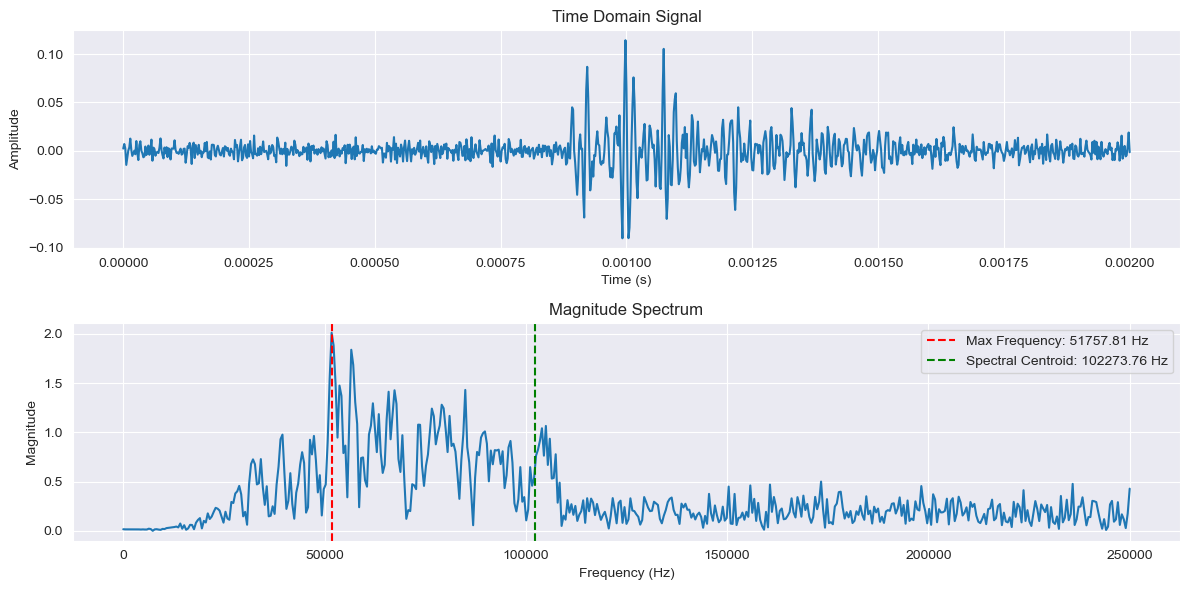

Basic feature extraction test completed successfully!


{'energy': 0.24597041,
 'energy_entropy': 1.4104083594473282,
 'spectral_entropy': 5.830924616992238,
 'max_frequency': 51757.8125,
 'spectral_centroid': 102273.7645348753,
 'zero_crossing_rate': 0.479,
 'energy_normalized': 0.24597041308879852,
 'energy_entropy_normalized': 0.6782630486009997,
 'spectral_entropy_normalized': 0.9344017414718421,
 'max_frequency_normalized': 0.20703125,
 'spectral_centroid_normalized': 0.4090950581395012,
 'zero_crossing_rate_normalized': 0.958}

In [14]:

def test_basic_feature_extraction():
    """Test basic feature extraction on a sample file"""
    # Find the first available audio file
    audio_file = None
    for category in categories:
        path = os.path.join(base_dir, category)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.wav')]
            if files:
                audio_file = os.path.join(path, files[0])
                break

    if audio_file is None:
        print("No audio files found!")
        return

    print(f"Testing basic feature extraction with file: {audio_file}")

    # Load audio to see what we're working with
    try:
        audio, sr = librosa.load(audio_file, sr=None)
        duration = len(audio) / sr
        print(f"Audio loaded: {len(audio)} samples at {sr}Hz (duration: {duration:.3f}s)")

        # Extract basic features
        features, magnitude_spectrum, n_fft = extract_basic_features(audio_file, n_subframes=8)

        # Print the features
        print("\nExtracted Features:")
        print(f"Energy: {features['energy']:.6f} (normalized: {features['energy_normalized']:.6f})")
        print(f"Energy Entropy: {features['energy_entropy']:.6f} (normalized: {features['energy_entropy_normalized']:.6f})")
        print(f"Spectral Entropy: {features['spectral_entropy']:.6f} (normalized: {features['spectral_entropy_normalized']:.6f})")
        print(f"Maximum Frequency: {features['max_frequency']:.2f} Hz (normalized: {features['max_frequency_normalized']:.6f})")
        print(f"Spectral Centroid: {features['spectral_centroid']:.2f} Hz (normalized: {features['spectral_centroid_normalized']:.6f})")
        print(f"Zero Crossing Rate: {features['zero_crossing_rate']:.6f} (normalized: {features['zero_crossing_rate_normalized']:.6f})")

        # Get the feature vector
        feature_vector = get_feature_vector(features)
        print(f"\nFeature Vector: {feature_vector}")

        # Plot magnitude spectrum
        plt.figure(figsize=(12, 6))

        # Plot time domain signal
        plt.subplot(2, 1, 1)
        plt.plot(np.arange(len(audio)) / sr, audio)
        plt.title('Time Domain Signal')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        # Plot magnitude spectrum
        plt.subplot(2, 1, 2)
        # Generate frequency axis (for rfft)
        freq_axis = np.fft.rfftfreq(n_fft, 1/sr)

        plt.plot(freq_axis, magnitude_spectrum)
        plt.axvline(x=features['max_frequency'], color='r', linestyle='--', label=f'Max Frequency: {features["max_frequency"]:.2f} Hz')
        plt.axvline(x=features['spectral_centroid'], color='g', linestyle='--', label=f'Spectral Centroid: {features["spectral_centroid"]:.2f} Hz')
        plt.title('Magnitude Spectrum')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("Basic feature extraction test completed successfully!")
        return features
    except Exception as e:
        print(f"Error during basic feature extraction: {e}")
        import traceback
        traceback.print_exc()


test_basic_feature_extraction()


## 2. Machine Learning Model Implementation

### A. SVM Classifier (Acoustic Box Recordings)
1. **Data Preparation**:
   - **Input Format**: Each sample should be preprocessed
   - **Sample Structure**: For each plant and condition, create a table with:
     - Row: One processed sound event
     - Columns: Extracted features + metadata (plant ID, species, condition)
   - **Train-Test Split**:
     - Implement leave-one-plant-out cross-validation (LOPO-CV)
     - Create a function that takes a plant ID as input and returns training and testing sets
     - For each fold, exclude all sounds from one specific plant for testing
   - **Balancing**: For each binary comparison, randomly undersample the larger class to match the smaller class size
   - **Normalization**: Apply StandardScaler (Z-score normalization) to all features
   - **Dimensionality Reduction**: Apply PCA, retaining components that explain 95% of variance


In [15]:
def extract_metadata_from_filename(filename):
    """
    Extract metadata (plant_id, sound_id) from filename

    Parameters:
    -----------
    filename : str
        Filename in format 'id_<plant_id>_sound_<sound_id>.wav'

    Returns:
    --------
    metadata : dict
        Dictionary containing plant_id and sound_id
    """
    # Use regex to extract plant_id and sound_id
    match = re.search(r'id_(\d+)_sound_?(\d+)\.wav', filename)

    if match:
        plant_id = int(match.group(1))
        sound_id = int(match.group(2))
        return {'plant_id': plant_id, 'sound_id': sound_id}
    else:
        # If pattern doesn't match, return default values
        print(f"Warning: Could not extract metadata from filename {filename}")
        return {'plant_id': -1, 'sound_id': -1}

def extract_all_features(file_path):
    """
    Extract all types of features from an audio file

    Parameters:
    -----------
    file_path : str
        Path to audio file

    Returns:
    --------
    all_features : dict
        Dictionary containing all extracted features
    """
    try:
        # Extract ScatNet features (deep scattering network)
        scatnet_features = extract_scatnet_features(file_path)

        # Extract MFCC features
        mfcc_features_raw = extract_mfcc_features(file_path)
        mfcc_features = summarize_mfcc_features(mfcc_features_raw)

        # Extract basic features
        basic_features_dict, _, _ = extract_basic_features(file_path)
        basic_features = get_feature_vector(basic_features_dict)

        # Combine all features
        return {
            'scatnet': scatnet_features,
            'mfcc': mfcc_features,
            'basic': basic_features
        }
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        import traceback
        traceback.print_exc()

        # Return empty features in case of error
        return {
            'scatnet': np.zeros(100),  # ScatNet features are 100-dimensional
            'mfcc': np.zeros(39 * 4),  # MFCC features after summarization (mean, std, max, min for each of 39 features)
            'basic': np.zeros(6)       # Basic features are 6-dimensional
        }

def create_dataset(base_dir, categories):
    """
    Create a dataset by processing all sound files in the specified categories

    Parameters:
    -----------
    base_dir : str
        Base directory containing category directories
    categories : list
        List of category (class) names

    Returns:
    --------
    dataset : pandas.DataFrame
        DataFrame containing features and metadata for each sound file
    """
    data = []

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        if not os.path.exists(category_dir):
            print(f"Warning: Directory {category_dir} does not exist")
            continue

        print(f"Processing {category}...")
        for filename in os.listdir(category_dir):
            if not filename.endswith('.wav'):
                continue

            file_path = os.path.join(category_dir, filename)

            # Extract metadata from filename
            metadata = extract_metadata_from_filename(filename)
            plant_id = metadata['plant_id']
            sound_id = metadata['sound_id']

            # Extract features
            features = extract_all_features(file_path)

            # Determine species and condition from category
            if 'Tomato' in category:
                species = 'Tomato'
            elif 'Tobacco' in category:
                species = 'Tobacco'
            else:
                species = 'None'  # For Empty Pot and Greenhouse Noises

            if 'Dry' in category:
                condition = 'Dry'
            elif 'Cut' in category:
                condition = 'Cut'
            else:
                condition = 'None'  # For Empty Pot and Greenhouse Noises

            # Create a data entry
            entry = {
                'file_path': file_path,
                'category': category,
                'plant_id': plant_id,
                'sound_id': sound_id,
                'species': species,
                'condition': condition,
                'scatnet_features': features['scatnet'],
                'mfcc_features': features['mfcc'],
                'basic_features': features['basic']
            }

            data.append(entry)

    # Create DataFrame
    df = pd.DataFrame(data)

    return df

def get_lopo_split(dataset, test_plant_id):
    """
    Create leave-one-plant-out train/test split

    Parameters:
    -----------
    dataset : pandas.DataFrame
        DataFrame containing features and metadata
    test_plant_id : int
        Plant ID to use for testing

    Returns:
    --------
    train_set : pandas.DataFrame
        Training set containing data from all plants except test_plant_id
    test_set : pandas.DataFrame
        Test set containing only data from test_plant_id
    """
    # Split dataset into train and test sets
    train_set = dataset[dataset['plant_id'] != test_plant_id].copy()
    test_set = dataset[dataset['plant_id'] == test_plant_id].copy()

    return train_set, test_set

def balance_binary_classes(dataset, class_column='category'):
    """
    Balance dataset by randomly undersampling the larger class

    Parameters:
    -----------
    dataset : pandas.DataFrame
        DataFrame containing features and metadata
    class_column : str
        Column name containing class labels

    Returns:
    --------
    balanced_dataset : pandas.DataFrame
        Balanced dataset with equal class sizes
    """
    # Count samples in each class
    class_counts = dataset[class_column].value_counts()

    if len(class_counts) != 2:
        raise ValueError("This function only works for binary classification tasks")

    # Identify smaller class size
    min_class_size = class_counts.min()

    # Create balanced dataset by undersampling larger class(es)
    balanced_data = []
    for class_name in class_counts.index:
        class_data = dataset[dataset[class_column] == class_name]
        if len(class_data) > min_class_size:
            # Randomly sample to match smaller class size
            class_data = class_data.sample(n=min_class_size, random_state=42)
        balanced_data.append(class_data)

    # Combine data from both classes
    balanced_dataset = pd.concat(balanced_data, ignore_index=True)

    return balanced_dataset

def normalize_and_reduce_dimensions(train_features, test_features, variance_threshold=0.95):
    """
    Normalize features and apply PCA for dimensionality reduction

    Parameters:
    -----------
    train_features : ndarray
        Training set features
    test_features : ndarray
        Test set features
    variance_threshold : float
        Proportion of variance to retain in PCA

    Returns:
    --------
    train_features_reduced : ndarray
        Normalized and dimensionality-reduced training features
    test_features_reduced : ndarray
        Normalized and dimensionality-reduced test features
    pca : sklearn.decomposition.PCA
        Fitted PCA model
    scaler : sklearn.preprocessing.StandardScaler
        Fitted scaler model
    """
    # Apply Z-score normalization
    scaler = StandardScaler()
    train_features_normalized = scaler.fit_transform(train_features)
    test_features_normalized = scaler.transform(test_features)

    # Apply PCA, retaining components that explain variance_threshold of variance
    pca = PCA(n_components=variance_threshold, svd_solver='full')
    train_features_reduced = pca.fit_transform(train_features_normalized)
    test_features_reduced = pca.transform(test_features_normalized)

    return train_features_reduced, test_features_reduced, pca, scaler

def prepare_binary_classification_data(dataset, class1, class2, test_plant_id, feature_type='all'):
    """
    Prepare data for binary classification between two classes

    Parameters:
    -----------
    dataset : pandas.DataFrame
        DataFrame containing features and metadata
    class1 : str
        First class name
    class2 : str
        Second class name
    test_plant_id : int
        Plant ID to use for testing
    feature_type : str
        Type of features to use: 'scatnet', 'mfcc', 'basic', or 'all'

    Returns:
    --------
    X_train : ndarray
        Training features
    y_train : ndarray
        Training labels
    X_test : ndarray
        Test features
    y_test : ndarray
        Test labels
    """
    # Filter dataset to include only the two specified classes
    binary_dataset = dataset[dataset['category'].isin([class1, class2])].copy()

    if len(binary_dataset) == 0:
        raise ValueError(f"No samples found for classes {class1} and {class2}")

    # Apply leave-one-plant-out split
    train_set, test_set = get_lopo_split(binary_dataset, test_plant_id)

    # Check if we have samples in both training and test sets
    if len(train_set) == 0:
        raise ValueError(f"No training samples found for plant_id {test_plant_id}")
    if len(test_set) == 0:
        test_samples = binary_dataset[binary_dataset['plant_id'] == test_plant_id]
        if len(test_samples) == 0:
            raise ValueError(f"Plant ID {test_plant_id} has no samples in either class")
        else:
            available_classes = test_samples['category'].unique()
            raise ValueError(f"Plant ID {test_plant_id} only has samples in classes: {available_classes}")

    # Check if we have samples from both classes in training set
    train_classes = train_set['category'].unique()
    if len(train_classes) < 2:
        raise ValueError(f"Training set contains only classes: {train_classes}")

    # Balance training set
    train_set = balance_binary_classes(train_set)

    # Convert class labels to binary values (0 for class1, 1 for class2)
    train_set['target'] = (train_set['category'] == class2).astype(int)
    test_set['target'] = (test_set['category'] == class2).astype(int)

    # Extract features based on specified feature_type
    try:
        if feature_type == 'scatnet':
            train_features = np.stack(train_set['scatnet_features'].values)
            test_features = np.stack(test_set['scatnet_features'].values)
        elif feature_type == 'mfcc':
            train_features = np.stack(train_set['mfcc_features'].values)
            test_features = np.stack(test_set['mfcc_features'].values)
        elif feature_type == 'basic':
            train_features = np.stack(train_set['basic_features'].values)
            test_features = np.stack(test_set['basic_features'].values)
        elif feature_type == 'all':
            # Concatenate all feature types
            train_features = np.hstack([
                np.stack(train_set['scatnet_features'].values),
                np.stack(train_set['mfcc_features'].values),
                np.stack(train_set['basic_features'].values)
            ])
            test_features = np.hstack([
                np.stack(test_set['scatnet_features'].values),
                np.stack(test_set['mfcc_features'].values),
                np.stack(test_set['basic_features'].values)
            ])
        else:
            raise ValueError(f"Invalid feature_type: {feature_type}")
    except Exception as e:
        raise ValueError(f"Error stacking features: {str(e)}")

    # Normalize and reduce dimensions
    X_train, X_test, _, _ = normalize_and_reduce_dimensions(train_features, test_features)

    # Extract labels
    y_train = train_set['target'].values
    y_test = test_set['target'].values

    return X_train, y_train, X_test, y_test

def get_unique_plant_ids(dataset):
    """
    Get list of unique plant IDs in dataset

    Parameters:
    -----------
    dataset : pandas.DataFrame
        DataFrame containing features and metadata

    Returns:
    --------
    plant_ids : list
        List of unique plant IDs
    """
    # Exclude invalid plant IDs (e.g., -1)
    plant_ids = sorted(dataset[dataset['plant_id'] > 0]['plant_id'].unique())
    return plant_ids


In [16]:
def save_feature_processing(feature_params, save_dir):
    """
    Save feature processing parameters

    Parameters:
    -----------
    feature_params : dict
        Dictionary containing MFCC and other feature parameters
    save_dir : str
        Directory to save parameters
    """
    params_path = os.path.join(save_dir, 'feature_params.joblib')
    joblib.dump(feature_params, params_path)

def save_dataset_features(dataset, save_dir):
    """
    Save extracted features

    Parameters:
    -----------
    dataset : pandas.DataFrame
        DataFrame containing features
    save_dir : str
        Directory to save features
    """
    features_path = os.path.join(save_dir, 'features.joblib')

    # Create a copy of the dataset with only the features
    feature_data = {
        'mfcc_features': dataset['mfcc_features'].values,
        'scatnet_features': dataset['scatnet_features'].values,
        'basic_features': dataset['basic_features'].values
    }

    joblib.dump(feature_data, features_path)

In [17]:
def test_data_preparation():
    """
    Test the data preparation pipeline
    """
    base_dir = 'data/PlantSounds'

    categories = [
        'Tomato Dry',
        'Empty Pot',
        'Greenhouse Noises',
        'Tobacco Cut',
        'Tobacco Dry',
        'Tomato Cut'
    ]

    # Create a small test dataset with limited files
    test_dataset = create_test_dataset(base_dir, categories, max_files_per_category=3)

    if test_dataset is None or len(test_dataset) == 0:
        print("Error: Could not create test dataset")
        return

    print(f"Created test dataset with {len(test_dataset)} samples")
    print("\nSample data:")
    print(test_dataset[['category', 'plant_id', 'sound_id', 'species', 'condition']].head())

    # Print class distribution
    print("\nClass distribution:")
    print(test_dataset['category'].value_counts())

    # Find two classes that have enough samples for binary classification
    class_counts = test_dataset['category'].value_counts()
    valid_classes = class_counts[class_counts >= 2].index.tolist()

    if len(valid_classes) < 2:
        print("Error: Not enough samples in any two classes for binary classification")
        return

    class1, class2 = valid_classes[:2]
    print(f"\nSelected classes for binary classification:")
    print(f"Class 1: {class1}")
    print(f"Class 2: {class2}")

    # Find a plant_id that has samples in at least one of the selected classes
    binary_dataset = test_dataset[test_dataset['category'].isin([class1, class2])]
    plant_ids_with_samples = binary_dataset['plant_id'].unique()
    plant_ids_with_samples = plant_ids_with_samples[plant_ids_with_samples > 0]  # Exclude invalid IDs

    if len(plant_ids_with_samples) == 0:
        print("Error: No valid plant IDs found for the selected classes")
        return

    print(f"\nPlant IDs with samples in selected classes: {plant_ids_with_samples}")

    # Try each plant ID until we find one that works
    success = False
    for test_plant_id in plant_ids_with_samples:
        try:
            print(f"\nTrying plant_id={test_plant_id}")

            # Get LOPO split for visualization
            train_set, test_set = get_lopo_split(binary_dataset, test_plant_id)
            print(f"LOPO split for plant_id={test_plant_id}:")
            print(f"Training set class distribution:\n{train_set['category'].value_counts()}")
            print(f"Test set class distribution:\n{test_set['category'].value_counts()}")

            # Try to prepare binary classification data
            X_train, y_train, X_test, y_test = prepare_binary_classification_data(
                test_dataset, class1, class2, test_plant_id
            )

            print(f"\nBinary classification data prepared successfully:")
            print(f"X_train shape: {X_train.shape}")
            print(f"y_train shape: {y_train.shape}")
            print(f"X_test shape: {X_test.shape}")
            print(f"y_test shape: {y_test.shape}")

            # Check class distribution
            print(f"\nTraining class distribution: {np.bincount(y_train)}")
            print(f"Test class distribution: {np.bincount(y_test)}")

            success = True
            break

        except Exception as e:
            print(f"Failed with plant_id={test_plant_id}: {str(e)}")
            continue

    if success:
        print("\nTest successful!")
    else:
        print("\nCould not find a suitable plant_id for binary classification")



In [18]:

def create_test_dataset(base_dir, categories, max_files_per_category=3):
    """
    Create a small test dataset for testing purpose

    Parameters:
    -----------
    base_dir : str
        Base directory containing category directories
    categories : list
        List of category (class) names
    max_files_per_category : int
        Maximum number of files to process per category

    Returns:
    --------
    test_dataset : pandas.DataFrame
        Small test dataset
    """
    data = []

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        if not os.path.exists(category_dir):
            print(f"Warning: Directory {category_dir} does not exist")
            continue

        print(f"Processing {category}...")
        wav_files = [f for f in os.listdir(category_dir) if f.endswith('.wav')]

        # Select a subset of files
        selected_files = wav_files[:max_files_per_category] if len(wav_files) > max_files_per_category else wav_files

        for filename in selected_files:
            file_path = os.path.join(category_dir, filename)

            # Extract metadata from filename
            metadata = extract_metadata_from_filename(filename)
            plant_id = metadata['plant_id']
            sound_id = metadata['sound_id']

            # Extract features
            features = extract_all_features(file_path)

            # Determine species and condition from category
            if 'Tomato' in category:
                species = 'Tomato'
            elif 'Tobacco' in category:
                species = 'Tobacco'
            else:
                species = 'None'  # For Empty Pot and Greenhouse Noises

            if 'Dry' in category:
                condition = 'Dry'
            elif 'Cut' in category:
                condition = 'Cut'
            else:
                condition = 'None'  # For Empty Pot and Greenhouse Noises

            # Create a data entry
            entry = {
                'file_path': file_path,
                'category': category,
                'plant_id': plant_id,
                'sound_id': sound_id,
                'species': species,
                'condition': condition,
                'scatnet_features': features['scatnet'],
                'mfcc_features': features['mfcc'],
                'basic_features': features['basic']
            }

            data.append(entry)

    # Create DataFrame
    if len(data) == 0:
        print("Warning: No data collected")
        return None

    df = pd.DataFrame(data)
    return df


test_data_preparation()


Processing Tomato Dry...
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Processing Empty Pot...
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta 

## 2. **Model Training**:
   - **SVM Configuration**:
     - Kernel: Radial basis function (RBF)
     - C parameter: Search in range [0.1, 1, 10, 100]
     - Gamma parameter: Search in range ['scale', 'auto', 0.001, 0.01, 0.1]
     - Optimization: Use 5-fold cross-validation on training data to find optimal hyperparameters
   - Implement separate models for each comparison pair
   - **Library**: Use sklearn.svm.SVC or LIBSVM Python bindings

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, balanced_accuracy_score
from itertools import combinations

In [20]:

def train_svm_model(X_train, y_train):
    """
    Train SVM model with optimized hyperparameters

    Parameters:
    -----------
    X_train : ndarray
        Training features
    y_train : ndarray
        Training labels

    Returns:
    --------
    best_model : sklearn.svm.SVC
        Trained SVM model with best parameters
    cv_results : dict
        Cross-validation results
    """
    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf']
    }

    # Create SVM classifier
    svm = SVC(random_state=42)

    # Create scorer that uses balanced accuracy
    scorer = make_scorer(balanced_accuracy_score)

    # Determine number of folds based on minimum class size
    class_counts = np.bincount(y_train)
    min_class_size = min(class_counts[class_counts > 0])
    n_folds = min(5, min_class_size)  # Use fewer folds if smallest class is small

    print(f"Class sizes: {class_counts}")
    print(f"Minimum class size: {min_class_size}")

    # Ensure we have at least 2 folds
    if n_folds < 2:
        print(f"Warning: Smallest class has only {min_class_size} samples. Using simple train-test split.")
        # Use default parameters and simple training
        best_params = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
        model = SVC(**best_params, random_state=42)
        model.fit(X_train, y_train)
        return model, {'params': best_params}

    print(f"Using {n_folds}-fold cross-validation")

    # Create grid search with adaptive number of folds
    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        cv=cv,
        scoring=scorer,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit grid search
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_, grid_search.cv_results_


In [21]:

def train_svm_model_gpu(X_train, y_train):
    """
    Train SVM model with GPU acceleration

    Parameters:
    -----------
    X_train : ndarray
        Training features
    y_train : ndarray
        Training labels

    Returns:
    --------
    best_model : thundersvm.SVC
        Trained SVM model with best parameters
    cv_results : dict
        Cross-validation results
    """
    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'kernel': ['rbf']
    }

    # Determine number of folds based on minimum class size
    class_counts = np.bincount(y_train)
    min_class_size = min(class_counts[class_counts > 0])
    n_folds = min(5, min_class_size)

    print(f"Class sizes: {class_counts}")
    print(f"Minimum class size: {min_class_size}")

    # If we have very few samples, use simple training
    if n_folds < 2:
        print(f"Warning: Smallest class has only {min_class_size} samples. Using simple train-test split.")
        best_params = {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
        model = thundersvm.SVC(
            **best_params,
            random_state=42,
            gpu_id=0  # Use first GPU
        )
        model.fit(X_train, y_train)
        return model, {'params': best_params}

    print(f"Using {n_folds}-fold cross-validation")

    # Create GPU-enabled SVM
    base_svm = thundersvm.SVC(
        random_state=42,
        gpu_id=0  # Use first GPU
    )

    # Create grid search with adaptive number of folds
    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Create custom grid search for ThunderSVM
    best_score = -1
    best_params = None
    best_model = None
    cv_results = {
        'params': [],
        'mean_test_score': [],
        'std_test_score': []
    }

    # Manual grid search with cross-validation
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            for kernel in param_grid['kernel']:
                params = {'C': C, 'gamma': gamma, 'kernel': kernel}
                scores = []

                # Cross-validation
                for train_idx, val_idx in cv.split(X_train, y_train):
                    X_train_fold = X_train[train_idx]
                    y_train_fold = y_train[train_idx]
                    X_val_fold = X_train[val_idx]
                    y_val_fold = y_train[val_idx]

                    # Train model
                    model = thundersvm.SVC(
                        **params,
                        random_state=42,
                        gpu_id=0
                    )
                    model.fit(X_train_fold, y_train_fold)

                    # Evaluate
                    score = model.score(X_val_fold, y_val_fold)
                    scores.append(score)

                # Calculate mean and std of scores
                mean_score = np.mean(scores)
                std_score = np.std(scores)

                # Store results
                cv_results['params'].append(params)
                cv_results['mean_test_score'].append(mean_score)
                cv_results['std_test_score'].append(std_score)

                # Update best if needed
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = params

    # Train final model with best parameters
    best_model = thundersvm.SVC(
        **best_params,
        random_state=42,
        gpu_id=0
    )
    best_model.fit(X_train, y_train)

    return best_model, cv_results

In [22]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model with proper handling of class labels

    Parameters:
    -----------
    model : sklearn.svm.SVC
        Trained SVM model
    X_test : ndarray
        Test features
    y_test : ndarray
        Test labels

    Returns:
    --------
    score : float
        Balanced accuracy score
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # If test set only has one class, return accuracy directly
    unique_classes = np.unique(y_test)
    if len(unique_classes) == 1:
        return float(np.all(y_pred == y_test))

    # Calculate balanced accuracy
    score = balanced_accuracy_score(y_test, y_pred)
    return score

def train_binary_classifiers(dataset, feature_type='all', min_samples_per_class=2, use_gpu=True):
    """
    Train binary SVM classifiers for all possible class pairs

    Parameters:
    -----------
    dataset : pandas.DataFrame
        Dataset containing features and metadata
    feature_type : str
        Type of features to use: 'scatnet', 'mfcc', 'basic', or 'all'
    min_samples_per_class : int
        Minimum number of samples required per class

    Returns:
    --------
    results : dict
        Dictionary containing trained models and results for each class pair
    """
    if use_gpu:
        import thundersvm  # You'll need to install this: pip install thundersvm

    # Get all unique categories
    categories = dataset['category'].unique()

    # Get class sizes
    class_sizes = dataset['category'].value_counts()
    print("\nOverall class sizes:")
    print(class_sizes)

    # Filter categories to those with enough samples
    valid_categories = class_sizes[class_sizes >= min_samples_per_class].index

    if len(valid_categories) < 2:
        raise ValueError(f"Need at least 2 classes with {min_samples_per_class} samples each")

    print(f"\nValid categories (>={min_samples_per_class} samples):")
    print(valid_categories)

    # Get all possible pairs of valid categories
    category_pairs = list(combinations(valid_categories, 2))

    # Dictionary to store results
    results = {}

    # Train a model for each pair
    for class1, class2 in category_pairs:
        print(f"\nTraining classifier for {class1} vs {class2}")

        pair_results = {
            'models': {},
            'cv_results': {},
            'best_params': {},
            'test_scores': [],
            'test_data': {}
        }

        # Get plant IDs that have samples in either class
        binary_dataset = dataset[dataset['category'].isin([class1, class2])]
        plant_ids = binary_dataset['plant_id'].unique()
        plant_ids = plant_ids[plant_ids > 0]  # Exclude invalid IDs

        print(f"Available plant IDs: {plant_ids}")

        for test_plant_id in plant_ids:
            try:
                print(f"\nTraining model for test_plant_id={test_plant_id}")

                # Prepare data
                X_train, y_train, X_test, y_test = prepare_binary_classification_data(
                    dataset, class1, class2, test_plant_id, feature_type
                )

                # Check if we have enough samples
                class_counts = np.bincount(y_train)
                print(f"Training set class distribution: {class_counts}")

                if min(class_counts) < min_samples_per_class:
                    print(f"Skipping: Not enough samples in training set (counts: {class_counts})")
                    continue

                # Train model with GPU if requested
                if use_gpu:
                    model, cv_results = train_svm_model_gpu(X_train, y_train)
                else:
                    model, cv_results = train_svm_model(X_train, y_train)

                # Store results
                pair_results['models'][test_plant_id] = model
                pair_results['cv_results'][test_plant_id] = cv_results
                pair_results['best_params'][test_plant_id] = model.get_params()

                # Evaluate on test set
                test_score = evaluate_model(model, X_test, y_test)
                pair_results['test_scores'].append(test_score)

                print(f"Best parameters: {model.get_params()}")
                print(f"Test score: {test_score:.3f}")
                print(f"Test set class distribution: {np.bincount(y_test)}")

            except Exception as e:
                print(f"Error training model for plant_id={test_plant_id}: {str(e)}")
                continue

        # Only store results if we successfully trained at least one model
        if len(pair_results['test_scores']) > 0:
            results[(class1, class2)] = pair_results

    return results

In [23]:
def plot_training_results(results):
    """
    Plot training results

    Parameters:
    -----------
    results : dict
        Dictionary containing training results
    """
    # Create figure
    plt.figure(figsize=(15, 10))

    # Plot test scores for each pair
    pairs = list(results.keys())
    scores = []
    std_scores = []

    for pair_result in results.values():
        if len(pair_result['test_scores']) > 0:
            scores.append(np.mean(pair_result['test_scores']))
            std_scores.append(np.std(pair_result['test_scores']))
        else:
            scores.append(0)
            std_scores.append(0)

    # Create pair labels
    pair_labels = [f"{p[0]}\nvs\n{p[1]}" for p in pairs]

    # Plot bar chart with error bars
    plt.bar(range(len(pairs)), scores, yerr=std_scores)
    plt.xticks(range(len(pairs)), pair_labels, rotation=45, ha='right')
    plt.ylabel('Balanced Accuracy')
    plt.title('Binary Classification Results')

    # Add horizontal line at 0.5 (random chance)
    plt.axhline(y=0.5, color='r', linestyle='--', label='Random Chance')
    plt.legend()

    # Ensure y-axis starts at 0
    plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()


Creating dataset...
Processing Tomato Dry...
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta widt

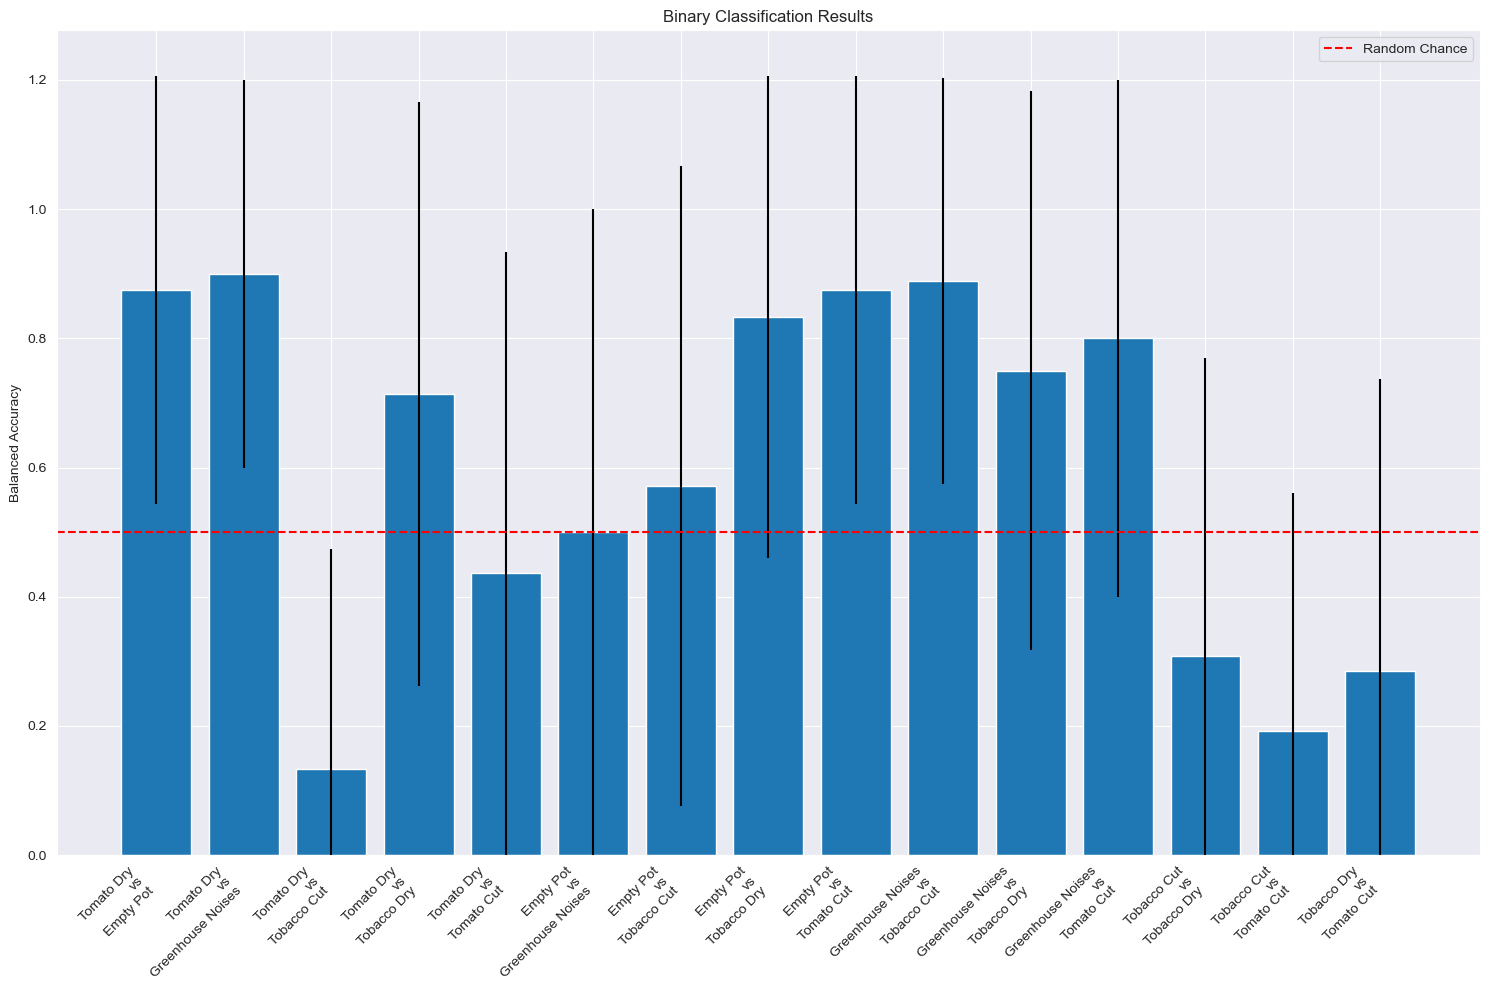


Test successful!


In [24]:
def test_model_training(use_gpu=True):
    """
    Test the model training pipeline
    """
    base_dir = 'data/PlantSounds'
    categories = [
        'Tomato Dry',
        'Empty Pot',
        'Greenhouse Noises',
        'Tobacco Cut',
        'Tobacco Dry',
        'Tomato Cut'
    ]

    # Create dataset with more samples per category
    print("Creating dataset...")
    dataset = create_test_dataset(base_dir, categories, max_files_per_category=10)

    if dataset is None or len(dataset) == 0:
        print("Error: Could not create dataset")
        return

    print(f"\nDataset created with {len(dataset)} samples")
    print("\nClass distribution:")
    print(dataset['category'].value_counts())

    print("\nTraining binary classifiers...")
    try:
        # Train models with minimum 2 samples per class requirement
        results = train_binary_classifiers(dataset, min_samples_per_class=2, use_gpu=use_gpu)

        if len(results) == 0:
            print("No models could be trained due to insufficient data")
            return

        # Print summary
        print("\nTraining completed. Summary:")
        for (class1, class2), pair_results in results.items():
            print(f"\n{class1} vs {class2}:")
            print(f"Number of models trained: {len(pair_results['models'])}")
            if len(pair_results['test_scores']) > 0:
                print(f"Average test score: {np.mean(pair_results['test_scores']):.3f} ± {np.std(pair_results['test_scores']):.3f}")

        # Plot results
        plot_training_results(results)

        print("\nTest successful!")

    except Exception as e:
        print(f"Error during model training: {str(e)}")
        import traceback
        traceback.print_exc()

test_model_training(use_gpu=False)

## 3. **Model Evaluation**:
   - **Metrics to Calculate**:
     - Balanced accuracy (average of sensitivity and specificity)
     - Precision, recall, F1-score for each class
     - Confusion matrix
   - **Statistical Testing**:
     - Use Wilcoxon rank-sum test to compare model performance against random (50%)
     - Apply Holm-Bonferroni correction for multiple comparisons
     - Report p-values and significance levels

In [25]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate classification metrics

    Parameters:
    -----------
    y_true : ndarray
        True labels
    y_pred : ndarray
        Predicted labels

    Returns:
    --------
    metrics : dict
        Dictionary containing various classification metrics
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Calculate sensitivity (recall of positive class) and specificity (recall of negative class)
    if cm.shape == (2, 2):  # Binary classification
        sensitivity = recall[1]  # True Positive Rate
        specificity = recall[0]  # True Negative Rate
        balanced_acc = (sensitivity + specificity) / 2
    else:
        sensitivity = specificity = balanced_acc = None

    return {
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'balanced_accuracy': balanced_acc
    }

In [26]:
def evaluate_binary_classifiers(results):
    """
    Evaluate binary classifiers with statistical testing

    Parameters:
    -----------
    results : dict
        Dictionary containing training results for each class pair

    Returns:
    --------
    evaluation : dict
        Dictionary containing evaluation results
    """
    evaluation = {}
    all_scores = []  # Collect all scores for multiple comparison correction

    # Process each pair of classes
    for (class1, class2), pair_results in results.items():
        print(f"\nEvaluating {class1} vs {class2}")

        pair_evaluation = {
            'models': {},
            'overall': {
                'test_scores': [],
                'statistical_test': None
            }
        }

        # Evaluate each model (one per test plant)
        for plant_id, model in pair_results['models'].items():
            # Get test data
            X_test = pair_results['test_data'][plant_id]['X_test']
            y_test = pair_results['test_data'][plant_id]['y_test']

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate metrics
            metrics = calculate_metrics(y_test, y_pred)

            # Store metrics for this model
            pair_evaluation['models'][plant_id] = metrics
            pair_evaluation['overall']['test_scores'].append(metrics['balanced_accuracy'])

        # Calculate average metrics across all models for this pair
        if pair_evaluation['overall']['test_scores']:
            scores = np.array(pair_evaluation['overall']['test_scores'])
            all_scores.append((class1, class2, scores))

            # Calculate mean and std of scores
            pair_evaluation['overall']['mean_score'] = np.mean(scores)
            pair_evaluation['overall']['std_score'] = np.std(scores)

            # Perform Wilcoxon test against random chance (0.5)
            if len(scores) > 1:  # Need at least 2 samples for Wilcoxon test
                statistic, p_value = wilcoxon(scores - 0.5)
                pair_evaluation['overall']['statistical_test'] = {
                    'statistic': statistic,
                    'p_value': p_value,
                    'n_samples': len(scores)
                }

        evaluation[(class1, class2)] = pair_evaluation

    # Apply Holm-Bonferroni correction
    if all_scores:
        # Collect p-values
        p_values = []
        pairs = []
        for class1, class2, scores in all_scores:
            if len(scores) > 1:
                _, p_value = wilcoxon(scores - 0.5)
                p_values.append(p_value)
                pairs.append((class1, class2))

        if p_values:
            # Apply correction
            reject, p_corrected, _, _ = multipletests(p_values, method='holm')

            # Store corrected p-values
            for (class1, class2), p_corr, rej in zip(pairs, p_corrected, reject):
                evaluation[(class1, class2)]['overall']['statistical_test'].update({
                    'p_value_corrected': p_corr,
                    'significant': rej
                })

    return evaluation

In [27]:
def print_evaluation_summary(evaluation):
    """
    Print summary of evaluation results
    """
    print("\nEvaluation Summary:")
    print("=" * 80)

    # Create a DataFrame for overall results
    results_data = []
    for (class1, class2), eval_results in evaluation.items():
        if 'overall' in eval_results:
            result = {
                'Classes': f"{class1} vs {class2}",
                'Mean Score': eval_results['overall'].get('mean_score', np.nan),
                'Std Score': eval_results['overall'].get('std_score', np.nan)
            }

            # Add statistical test results if available
            if eval_results['overall'].get('statistical_test'):
                stats = eval_results['overall']['statistical_test']
                result.update({
                    'p-value': stats.get('p_value', np.nan),
                    'p-value (corrected)': stats.get('p_value_corrected', np.nan),
                    'Significant': stats.get('significant', False)
                })

            results_data.append(result)

    # Create and display DataFrame
    results_df = pd.DataFrame(results_data)
    print("\nOverall Results:")
    print(results_df.to_string(index=False))

    # Print detailed results for each pair
    print("\nDetailed Results:")
    print("=" * 80)
    for (class1, class2), eval_results in evaluation.items():
        print(f"\n{class1} vs {class2}:")
        for plant_id, metrics in eval_results['models'].items():
            print(f"\nPlant ID: {plant_id}")
            print(f"Confusion Matrix:\n{metrics['confusion_matrix']}")
            print(f"Precision: {metrics['precision']}")
            print(f"Recall: {metrics['recall']}")
            print(f"F1-score: {metrics['f1_score']}")
            print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.3f}")

def plot_evaluation_results(evaluation):
    """
    Create visualizations of evaluation results
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # 1. Bar plot of balanced accuracy scores
    ax1 = axes[0, 0]
    pairs = []
    means = []
    stds = []
    for (class1, class2), eval_results in evaluation.items():
        if 'overall' in eval_results:
            pairs.append(f"{class1}\nvs\n{class2}")
            means.append(eval_results['overall']['mean_score'])
            stds.append(eval_results['overall']['std_score'])

    ax1.bar(range(len(pairs)), means, yerr=stds)
    ax1.set_xticks(range(len(pairs)))
    ax1.set_xticklabels(pairs, rotation=45, ha='right')
    ax1.set_ylabel('Balanced Accuracy')
    ax1.set_title('Classification Performance')
    ax1.axhline(y=0.5, color='r', linestyle='--', label='Random Chance')
    ax1.legend()

    # 2. Heatmap of average confusion matrices
    ax2 = axes[0, 1]
    avg_cm = np.zeros((2, 2))
    cm_count = 0
    for eval_results in evaluation.values():
        for metrics in eval_results['models'].values():
            avg_cm += metrics['confusion_matrix']
            cm_count += 1
    if cm_count > 0:
        avg_cm = avg_cm / cm_count
    sns.heatmap(avg_cm, annot=True, fmt='.2f', ax=ax2)
    ax2.set_title('Average Confusion Matrix')

    # 3. Box plot of performance metrics
    ax3 = axes[1, 0]
    metric_data = {
        'Precision': [],
        'Recall': [],
        'F1-score': []
    }
    for eval_results in evaluation.values():
        for metrics in eval_results['models'].values():
            metric_data['Precision'].extend(metrics['precision'])
            metric_data['Recall'].extend(metrics['recall'])
            metric_data['F1-score'].extend(metrics['f1_score'])

    sns.boxplot(data=pd.DataFrame(metric_data), ax=ax3)
    ax3.set_title('Distribution of Performance Metrics')

    # 4. Statistical significance plot
    ax4 = axes[1, 1]
    sig_data = []
    for (class1, class2), eval_results in evaluation.items():
        if 'overall' in eval_results and eval_results['overall'].get('statistical_test'):
            stats = eval_results['overall']['statistical_test']
            sig_data.append({
                'Pair': f"{class1} vs {class2}",
                'p-value': stats.get('p_value_corrected', np.nan),
                'Significant': stats.get('significant', False)
            })

    if sig_data:
        sig_df = pd.DataFrame(sig_data)
        sig_df = sig_df.sort_values('p-value')
        ax4.bar(range(len(sig_df)), -np.log10(sig_df['p-value']),
                color=[('green' if sig else 'red') for sig in sig_df['Significant']])
        ax4.set_xticks(range(len(sig_df)))
        ax4.set_xticklabels(sig_df['Pair'], rotation=45, ha='right')
        ax4.axhline(y=-np.log10(0.05), color='k', linestyle='--', label='p=0.05')
        ax4.set_ylabel('-log10(p-value)')
        ax4.set_title('Statistical Significance')
        ax4.legend()

    plt.tight_layout()
    plt.show()


In [28]:
# Test the evaluation
def test_model_evaluation(results):
    """
    Test the model evaluation pipeline
    """
    print("Evaluating models...")
    evaluation = evaluate_binary_classifiers(results)

    print("\nPrinting evaluation summary...")
    print_evaluation_summary(evaluation)

    print("\nPlotting evaluation results...")
    plot_evaluation_results(evaluation)

    print("\nEvaluation test successful!")


## 4. Wrap-up

In [29]:
def create_full_dataset(base_dir, categories):
    """
    Create dataset using all available files

    Parameters:
    -----------
    base_dir : str
        Base directory containing category directories
    categories : list
        List of category names

    Returns:
    --------
    dataset : pandas.DataFrame
        DataFrame containing all data
    """
    print("Creating full dataset...")
    dataset = create_dataset(base_dir, categories)  # Use the original create_dataset function

    print(f"\nDataset created with {len(dataset)} samples")
    print("\nClass distribution:")
    print(dataset['category'].value_counts())

    return dataset

In [30]:
import joblib
from datetime import datetime

def save_models(results, base_save_dir='saved_models'):
    """
    Save trained models and results

    Parameters:
    -----------
    results : dict
        Dictionary containing training results
    base_save_dir : str
        Base directory for saving models
    """
    # Create timestamp for the save directory
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = os.path.join(base_save_dir, f'models_{timestamp}')

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Save each model
    for (class1, class2), pair_results in results.items():
        # Create pair directory
        pair_dir = os.path.join(save_dir, f"{class1}_vs_{class2}")
        os.makedirs(pair_dir, exist_ok=True)

        # Save models
        for plant_id, model in pair_results['models'].items():
            model_path = os.path.join(pair_dir, f"model_plant_{plant_id}.joblib")
            joblib.dump(model, model_path)

        # Save other results
        results_path = os.path.join(pair_dir, "results.joblib")
        # Create a copy of results without the model objects
        save_results = pair_results.copy()
        save_results['models'] = {k: f"model_plant_{k}.joblib" for k in save_results['models'].keys()}
        joblib.dump(save_results, results_path)

    print(f"\nModels and results saved in: {save_dir}")
    return save_dir

def save_experiment(dataset, results, feature_params, base_save_dir='saved_experiments'):
    """
    Save complete experiment including models, features, and parameters

    Parameters:
    -----------
    dataset : pandas.DataFrame
        Dataset with features
    results : dict
        Dictionary containing training results
    feature_params : dict
        Dictionary containing feature extraction parameters
    base_save_dir : str
        Base directory for saving
    """
    # Create timestamp for the save directory
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    save_dir = os.path.join(base_save_dir, f'experiment_{timestamp}')

    # Create directory
    os.makedirs(save_dir, exist_ok=True)

    # Save models
    models_dir = os.path.join(save_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)
    for (class1, class2), pair_results in results.items():
        # Create pair directory
        pair_dir = os.path.join(models_dir, f"{class1}_vs_{class2}")
        os.makedirs(pair_dir, exist_ok=True)

        # Save models
        for plant_id, model in pair_results['models'].items():
            model_path = os.path.join(pair_dir, f"model_plant_{plant_id}.joblib")
            joblib.dump(model, model_path)

        # Save other results
        results_path = os.path.join(pair_dir, "results.joblib")
        save_results = pair_results.copy()
        save_results['models'] = {k: f"model_plant_{k}.joblib" for k in save_results['models'].keys()}
        joblib.dump(save_results, results_path)

    # Save feature processing parameters
    save_feature_processing(feature_params, save_dir)

    # Save dataset features
    save_dataset_features(dataset, save_dir)

    # Save metadata
    metadata = {
        'timestamp': timestamp,
        'n_samples': len(dataset),
        'categories': dataset['category'].unique().tolist(),
        'feature_types': ['mfcc', 'scatnet', 'basic']
    }
    metadata_path = os.path.join(save_dir, 'metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    print(f"\nExperiment saved in: {save_dir}")
    return save_dir


In [31]:
def load_models(model_dir):
    """
    Load saved models and results

    Parameters:
    -----------
    model_dir : str
        Directory containing saved models

    Returns:
    --------
    results : dict
        Dictionary containing loaded models and results
    """
    results = {}

    # Get all pair directories
    pair_dirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]

    for pair_dir in pair_dirs:
        # Extract class names from directory name
        class1, class2 = pair_dir.split('_vs_')

        # Load results
        results_path = os.path.join(model_dir, pair_dir, "results.joblib")
        pair_results = joblib.load(results_path)

        # Load models
        models = {}
        for plant_id, model_file in pair_results['models'].items():
            model_path = os.path.join(model_dir, pair_dir, model_file)
            models[plant_id] = joblib.load(model_path)

        # Restore models in results
        pair_results['models'] = models
        results[(class1, class2)] = pair_results

    print(f"\nLoaded models from: {model_dir}")
    return results

In [32]:
def svm_main(use_gpu=True, feature_cache_dir='cached_features'):
    """
    Main function to run the complete pipeline
    """
    # Setup
    base_dir = 'data/PlantSounds'
    categories = [
        'Tomato Dry',
        'Empty Pot',
        'Greenhouse Noises',
        'Tobacco Cut',
        'Tobacco Dry',
        'Tomato Cut'
    ]

    # Feature extraction parameters
    feature_params = {
        'mfcc': {
            'n_mfcc': 13,
            'n_mels': 40,
            'n_fft': 1024,
            'hop_length': 250,
            'fmin': 20,
            'fmax': 8000
        },
        'basic': {
            'frame_length': 500,
            'hop_length': 250
        },
        'scatnet': {
            'J': 3,
            'Q': 8
        }
    }

    # Create cache directory if it doesn't exist
    os.makedirs(feature_cache_dir, exist_ok=True)

    # Define cache paths
    dataset_cache_path = os.path.join(feature_cache_dir, 'dataset.joblib')
    features_cache_path = os.path.join(feature_cache_dir, 'features.joblib')
    params_cache_path = os.path.join(feature_cache_dir, 'params.joblib')

    # Try to load cached dataset and features
    try:
        print("Looking for cached features...")
        dataset = joblib.load(dataset_cache_path)
        cached_params = joblib.load(params_cache_path)

        # Check if cached parameters match current parameters
        if cached_params == feature_params:
            print("Found cached features with matching parameters")
        else:
            print("Cached feature parameters don't match, recomputing features")
            raise FileNotFoundError

    except (FileNotFoundError, ValueError) as e:
        print("No cached features found or parameters mismatch, creating new dataset...")

        # Create full dataset
        dataset = create_full_dataset(base_dir, categories)

        # Save dataset and parameters
        print("Caching features...")
        joblib.dump(dataset, dataset_cache_path)
        joblib.dump(feature_params, params_cache_path)
        print("Features cached successfully")

    # Train models
    print("\nTraining binary classifiers...")
    results = train_binary_classifiers(dataset, min_samples_per_class=2, use_gpu=use_gpu)

    # Save experiment
    save_dir = save_experiment(dataset, results, feature_params)

    # Evaluate models
    print("\nEvaluating models...")
    evaluation = evaluate_binary_classifiers(results)

    # Print and plot results
    print_evaluation_summary(evaluation)
    plot_evaluation_results(evaluation)

    return dataset, results, evaluation, save_dir

In [33]:
# train
dataset, results, evaluation, save_dir = svm_main(use_gpu=False)

print("save_dir", save_dir)


Looking for cached features...
No cached features found or parameters mismatch, creating new dataset...
Creating full dataset...
Processing Tomato Dry...
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio to 1500 samples
Using n_fft=1024
Using n_mels=40, fmin=20Hz, fmax=8000Hz
MFCC shape: (13, 7)
Using delta width=5
Using n_fft=1024 for a signal of length 1001
Audio duration: 2.00 ms
Using window_length=500 samples, hop_length=250 samples
Padded audio 

KeyboardInterrupt: 

In [ ]:

# Later, you can load the models:
# loaded_results = load_models(save_dir)

In [34]:
def predict_with_voting(models_dict, features, categories):
    """
    Make predictions using voting among binary classifiers

    Parameters:
    -----------
    models_dict : dict
        Dictionary containing trained binary classifiers
    features : dict/array
        Features of the audio sample to classify
    categories : list
        List of all possible categories

    Returns:
    --------
    predicted_class : str
        Predicted category
    confidence_scores : dict
        Confidence scores for each category
    """
    # Initialize vote counts for each category
    votes = {category: 0 for category in categories}

    # Initialize pairwise decisions counter
    decisions = {category: {'wins': 0, 'total': 0} for category in categories}

    # For each binary classifier
    for (class1, class2), pair_results in models_dict.items():
        # Get the average prediction across all plant-specific models
        predictions = []

        for model in pair_results['models'].values():
            try:
                # Make prediction (returns probability of class2)
                pred = model.predict_proba(features.reshape(1, -1))[0][1]
                predictions.append(pred)
            except Exception as e:
                print(f"Error in prediction for {class1} vs {class2}: {e}")
                continue

        if predictions:
            # Average the predictions
            avg_pred = np.mean(predictions)

            # Determine winner
            winner = class2 if avg_pred > 0.5 else class1

            # Update decision counts
            decisions[class1]['total'] += 1
            decisions[class2]['total'] += 1
            decisions[winner]['wins'] += 1

    # Calculate confidence scores
    confidence_scores = {}
    for category in categories:
        total = decisions[category]['total']
        if total > 0:
            confidence_scores[category] = decisions[category]['wins'] / total
        else:
            confidence_scores[category] = 0.0

    # Select the category with highest confidence
    predicted_class = max(confidence_scores.items(), key=lambda x: x[1])[0]

    return predicted_class, confidence_scores

def classify_audio(file_path, models_dict, feature_params, categories):
    """
    Classify a new audio file using the trained models

    Parameters:
    -----------
    file_path : str
        Path to the audio file to classify
    models_dict : dict
        Dictionary containing trained binary classifiers
    feature_params : dict
        Parameters used for feature extraction
    categories : list
        List of all possible categories

    Returns:
    --------
    predicted_class : str
        Predicted category
    confidence_scores : dict
        Confidence scores for each category
    """
    # Extract features
    features = extract_all_features(file_path)

    # Combine all features (as done during training)
    combined_features = np.hstack([
        features['scatnet'],
        features['mfcc'],
        features['basic']
    ])

    # Make prediction using voting
    predicted_class, confidence_scores = predict_with_voting(
        models_dict,
        combined_features,
        categories
    )

    return predicted_class, confidence_scores


In [36]:
# Example usage:
def test_classifier(save_dir):
    """Test the multi-class classifier on a sample file"""
    # Load saved models
    models_dict = load_models(save_dir)

    # Find a test file
    test_file = None
    for category in categories:
        path = os.path.join(base_dir, category)
        if os.path.exists(path):
            files = [f for f in os.listdir(path) if f.endswith('.wav')]
            if files:
                test_file = os.path.join(path, files[0])
                true_category = category
                break

    if test_file is None:
        print("No test file found!")
        return

    # Make prediction
    predicted_class, confidence_scores = classify_audio(
        test_file,
        models_dict,
        feature_params,
        categories
    )

    # Print results
    print(f"\nTest file: {test_file}")
    print(f"True category: {true_category}")
    print(f"Predicted category: {predicted_class}")
    print("\nConfidence scores:")
    for category, score in confidence_scores.items():
        print(f"{category}: {score:.3f}")

test_classifier(save_dir="saved_experiments/experiment_20250415_022756/models")

FileNotFoundError: Please build the library first!

In [20]:


def train_model(X_train, Y_train, vb=0):
    ### Hyper parameters ###
    batch_size = 64
    num_epochs = 50
    kernel_size = 9
    pool_size = 4
    conv_depth_1 = 32
    conv_depth_2 = 64
    conv_depth_3 = 128
    drop_prob_1 = 0.5
    drop_prob_2 = 0.5
    drop_prob_3 = 0.5
    hidden_size = 128

    ### generating the network ###
    model = Sequential()

    # 1st conv block #
    model.add(Conv1D(conv_depth_1, kernel_size=kernel_size, input_shape=(1001, 1), \
                            padding='same', activation='relu'))
    model.add(Conv1D(conv_depth_1, kernel_size=kernel_size, \
                            padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(drop_prob_1))

    # 2nd conv block #
    model.add(Conv1D(conv_depth_2, kernel_size=kernel_size, \
                            padding='same', activation='relu'))
    model.add(Conv1D(conv_depth_2, kernel_size=kernel_size, \
                            padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(drop_prob_1))

    # 3rd conv block #
    if conv_depth_3 > 0:
        model.add(Conv1D(conv_depth_3, kernel_size=kernel_size, \
                                padding='same', activation='relu'))
        model.add(Conv1D(conv_depth_3, kernel_size=kernel_size, \
                                padding='same', activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(drop_prob_3))

    # Dense layers #
    model.add(Flatten())
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dropout(drop_prob_2))
    model.add(Dense(1, activation='sigmoid'))

    # Complie #
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

    # Fit #
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
    model.fit(X_train, Y_train, epochs=num_epochs, \
              batch_size=batch_size, verbose=vb, \
              class_weight={0: class_weights[0], 1: class_weights[1]})

    return model